# Seismic Data Processing and HVSR

---

# Introduction

Seismology is one of the oldest and largest branches of geophysics. 
Seismic data is somewhat unique in its breadth of application: from planet-scale studies to hyper-local site characterization. In large part because of the global nature of seismic phenomena and because of the highly destructive potential of earthquakes, seismic data is highly organized and is shared globally. Countries develop their own seismometer networks, the data from which are often available to be downloaded or "streamed" online. Seismic data has many national security implications: it is used to detect nuclear tests, monitor border crossings, and explore for mineral or oil resources.

Seismic data (as well as HVSR specifically, which we will focus on here) is also one of the only types of data collected on Earth, the Moon, and Mars.

A basic understanding of seismic data, processing, and terminology is often expected in most roles having to do with geopysics.
Environmental applications of seismic geophysical data are not as common as, for example, GPR and ERT.
Understanding how to work with seismic data is still important for those working in environmental geophysics for a number of reason:
* Seismic data and terminology can be used in many environmental applications
* Many of the processing techniques used in GPR are directly analogous to (if not exactly the same as) techniques developed for seismology
* Seismic data have many near-surface applications that will often overlap with environmental investigations

---

## Seismic Data

Seismic data is at its core time-series data, and many of the processing techniques used in seismology are analagous to (if not exactly the same as) techniques used in and developed for broader signal processing algorithms.

You should have an understanding of basic seismic terminology, but some terms worth emphasizing are included below:

### General seismological terms:

* **Seismometer**: an instrument that measures seismic data
* **Seismic Network**: a collection of seismic stations, often managed by a single entity and with a singular purposes
* **Seismic Station**: a seismometer (or multiple seismometers) that has been given a specific identifying code. Often, this is formatted as follows:
    * NETWORK_NAME.STATION_NAME.LOCATION.CHANNEL
* **Channel**: Often, the basic data feed or measurement coming out of a seismometer (or similar instrument). Many seismometer have more than one channel.
    * These channels often consist of data read from a single geophone
    * Among the most common configurations is a three-component seismometer: a vertical geophone, a horizontal geophone facing "East", and an orthogonal horizontal geophone facing "north"
* **Geophone**: a device contained within a seismometer that measures ground motion
    * The data from a geophone is often recorded as one channel in a seismometer's data record
* **Component**: Often used interchangeably with "channel", but more specifically refers to directionality of the geophone
    * The term **channel** implies a single set of data from a single geophone with consistent parameters

### Terms or classes with a specific usage in Obspy
* **Trace**: the basic building block of seismic data in Obspy
    * A trace is a class in obspy that consists of a single stream of data and its associated metadata
    * The time component of an obspy trace is always in UTC time
    * Traces can have gaps in time, which can either be "merged" as a single trace with a "masked" array or "split" into multiple traces.
    * Much of a trace's metadata is contained in its "stats" attribute
* **Stream**: a collection of seismic data in Obspy, often the most basic data type read in from a real data source
    * Streams consist of multiple traces. For example, the data from a three component seismometer ideally consists of three traces collected into in a single stream
    * Most of the obspy functions or methods that work on streams actually perform on the individual traces in the stream.
* **UTC**: "Universal time coordinates," similar to an official scientific "time zone"
    * For the most part, it is aligned with Greenwich Mean Time (i.e., the time in England)
    * In obspy, these time coordinates are implented as `UTCDateTime` objects
    * `UTCDateTime` is a class to standardize the time dimension of seismic data, but also has varous methods and attributes that allow manipulation from other common python time objects (such as objects in the Datetime module of the python standard library and matplotlib times for plotting)

---

# Seismic Data: Data in time

One of the most important aspects of seismic data is the time dimension. In fact, modern seismology depends almost entirely on the ability to accurately and precisely measure when ground motion occured. It is perhaps as important as the magnitude of the ground motion itself.

In order to work with time, we should first try understand the objects used for time in python.

There was a relatively large change in how python deals with time natively that was released with python version 3.9, so please ensure you have version 3.9 or greater installed.

The primary time and date module in python's standard library is called `datetime`. The following is a non-comprehensive overview of python packages that deal with time:

### Standard library (installed with python itself)
* **datetime**: The primary python module for creating and dealing with dates and times
    * **date**: similar to and compatible with datetime, but only uses dates
    * **time**: simliar to and compatible with datetime, but only deals with times
    * **tzinfo**: module for creating timezone objects, converting between timezones, etc.
        * **timezone**: class for working with timezones and offsets from UTC, for example
    * **timedelta**: module for getting the difference between two datetime values


### 3rd-Party Libraries
* **pytz**: installed as a dependency in pandas, pytz brings the [Olson (or IANA) timezone database](https://en.wikipedia.org/wiki/Tz_database) into Python
* **tzdata**: a python data-only package that provides access to [Internet Assigned Numbers Authority (IANA) timezone database](https://www.iana.org/time-zones)
* **matplotlib.pyplot.time**: submodule of matplotlib's pyplot that allows manipulation of time
* **UTCDateTime**: a module of the obspy package, this is the primary object used to represent time in obspy


Let's first familiarize ourselves with the datetime module.

The datetime module contains several submodules. One is also called `datetime`. The `date` and `time` submodules are, to put it in a simple way, essentially one half each of the `datetime` class. (technically, `datetime` is a subclass of the `date` class)

You can create a time object (at midnight: 00:00:00) with the following code. You can add arguments for hours, minutes, seconds, microseconds, and timezone information.

In [106]:
import datetime
# Create a time object at midnight
midnightTime = datetime.time()
#this is the same as datetime.time(hour=0, minute=0, second=0, microsecond=0)
print(midnightTime)
oneSecond5MicrosAfterMidnight = datetime.time(hour=0, minute=0, second=1, microsecond=5)
print(oneSecond5MicrosAfterMidnight)
midnightTime

00:00:00
00:00:01.000005


datetime.time(0, 0)

Now, that may be useful enough, but...which midnight do we mean (i.e., where on earth?). This is not specified by default with native datetime objects, but we can make these objects timezone-aware.

In [154]:
import datetime
import zoneinfo
usc = zoneinfo.ZoneInfo('US/Central') #"US/Central" is the IANA name for 
uscMidnight = datetime.time(tzinfo=usc)
uscMidnight

datetime.time(0, 0, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

A printout of available timezones can be printed using the following code (this is a set of officially-recognized timezone names):

In [ ]:
import zoneinfo
zoneinfo.available_timezones()

There is actually more that can be done on `datetime.datetime` objects with timezones. 

For example, let's say that we acquire data in the field using our local time (e.g., Central Time in the U.S.).

However, our seismic data is likely to be in UTC. If we want to programatically "translate" this time, we can do so! Let's first define a `datetime` object in our local ('US/Central' in this case) timezone.

In [135]:
import datetime
import zoneinfo
# First, define the date and timezone
usc = zoneinfo.ZoneInfo('US/Central')

# specifying tzinfo makes datetimes timezone-aware
oct102010=datetime.datetime(2010, 10, 10, 5, 10, tzinfo=usc)
# same as: oct102010=datetime.datetime(year=2010, month=10, day=10, hour=5, minute=10, tzinfo=usc)

print(oct102010)
oct102010

2010-10-10 05:10:00-05:00


datetime.datetime(2010, 10, 10, 5, 10, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

Now, let's convert that timezone-aware datetime object to UTC

In [136]:
oct102010UTC = oct102010.astimezone(zoneinfo.ZoneInfo('UTC'))
print(oct102010UTC)
oct102010UTC

2010-10-10 10:10:00+00:00


datetime.datetime(2010, 10, 10, 10, 10, tzinfo=zoneinfo.ZoneInfo(key='UTC'))

We are able (only relatively recently) to get `datetime` objects from the standard library specifically into UTC.

Even so, python's native datetime module is not the most robust or intuitive for specifying times in UTC, which is very important for seismic data!

So, the Obspy module has its own class for keeping track of datetimes to avoid this confusion (and to add useful functionality). This class is called `UTCDateTime`.

For example, rather than microsecond precision out of the box, the `UTCDateTime` has nanosecond precision. There is also no confusion as to what timezone the time data is in, since it is always in UTC.

`UTCDateTime` can be called similarly to the native python `datetime.datetime` class (i.e., by specifying year, month, day, etc.), but it also has many more options to maintain compatibility with a variety of seismic systems.

For example, one of the more commonly used alternative date specifiers is called the "Julian day" which in this case essentially means the day of the year (e.g., Feb 1 would be the 32nd day of the year). The Julian Day can be used both for input and out output of `UTCDateTime` objects.

Obspy's UTCDateTime can easily determine this value, see below:

In [151]:
import obspy
oct102010UTCDT = obspy.UTCDateTime(2010, 10, 10, 5, 10)
print(oct102010UTCDT.julday)

283


Ok, practice on your own. We want to create a `UTCDateTime` object for the due date and time of this assignment (March 2, 2025 at 11:59pm and 59 seconds and  999,999 microseconds CENTRAL TIME).

First, create a timezone-aware datetime object 

In [16]:
import datetime
import zoneinfo
centralDT = datetime.datetime(2025, 3, 15, 23, 59, 59, 999999, tzinfo=zoneinfo.ZoneInfo("US/Central"))
obspy.UTCDateTime(centralDT)

2025-03-16T04:59:59.999999Z

Now, translate it to a timezone of your choice (can be your home timezone if that is different than "US/Central", UTC, or whatever you choose!)

In [ ]:
# Convert the time to a timezone of your choice!


# Q1: What time zone did you convert to (Use the official IANA name, e.g., from the "available_timezones()" command)? Copy the printout of the time as well.

---

Now, let's say you were granted a 12-hour extension.

To do this in the native python datetime module, you will need to use a timedelta object, see below:

In [23]:
centralDT + datetime.timedelta(hours=12)

datetime.datetime(2025, 3, 16, 11, 59, 59, 999999, tzinfo=zoneinfo.ZoneInfo(key='US/Central'))

This can be done more directly with `UTCDateTime` objects. With UTCDateTime objects, you can use `+` and `-` to calculate changes in time. The default unit is seconds. So, use your answer from the previous cell (Q1) and add 12 hours to it (hint: how many seconds in an hour?)

In [29]:
#You can read a timezone-aware datetime object into UTCDateTime fairly easily:
centralDTUTC = obspy.UTCDateTime(centralDT)
print("centralDT variable in UTC: ", centralDTUTC)

twelve_hours_in_seconds = 

twelveHrExt = centralDTUTC + twelve_hours_in_seconds
print("   with 12 hour extension: ", twelveHrExt)

centralDT variable in UTC:  2025-03-16T04:59:59.999999Z
   with 12 hour extension:  2025-03-16T16:59:59.999999Z


# Q2: Copy/paste your UTCDateTime printout with the 12-hour-extension as your answer.

---

# Seismic Data: traces and streams

Now, let's take a look at how data is stored and organized in obspy.

You can read a short, sample dataset using obspy using `obspy.read()`. 

Normally, we would enter a filepath between the parentheses of the `read()` function. If we leave it blank, we will get a sample dataset.

Read in that sample data stream below.

In [4]:
import obspy
sampleStream = obspy.read()

There are a few different ways to see what our dataset looks like. One is to simply print the string representation of the obspy Stream object.

This will give a heading with the number of traces in the stream, and a brief summary of each stream.

In [189]:
print(sampleStream)

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


When you iterate through a Stream object (using a `for` loop, for example), it will go through each Trace object contained in the Stream object.

This looks similar to printing the Stream object, but it does not contain the "header".

In [ ]:
# Loop through traces
for trace in sampleStream:
    print('TRACE INFORMATION:', trace)

You can also simply plot a stream, which will produce an individual subplot for each trace.

Setting it equal to a variable will save the matplotlib figure into that variable.

In [2]:
samplePlot = sampleStream.plot()


NameError: name 'sampleStream' is not defined

Now, if we want to extract a specific trace from the stream, we have a few options.

You can using indexing, just as if the traces were in a list. Note the data type this returns (i.e., an obspy Trace)

In [5]:
firstTrace = sampleStream[0]
zTrace = firstTrace # This just happens to be the Z trace
print(type(zTrace))
print(zTrace)

<class 'obspy.core.trace.Trace'>
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


We can also use the `.select()` method of the obspy streams to select all traces (only one in this instance) with a specific parameter.

In this case, we'll select all traces in our stream from the "EHE" channel. (There can be multiple EHE channel traces if, for example, there is a large time gap in the data or if there are multiple stations' stream in the Stream object you are using). 

You can select using many attributes via the `.select()` method. In this case, we are selecting using the "channel" attribute.

Note the data type that the `.select()` method returns (i.e., an obspy Stream). Even though there is only one Trace in this Stream, the `.select()` method returns a Stream. 

Later, we can use the indexing selection again to isolate a trace as needed.

In [6]:
eTraceStream = sampleStream.select(channel='EHE')
print(type(eTraceStream))
print(eTraceStream)

<class 'obspy.core.stream.Stream'>
1 Trace(s) in Stream:
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


You can also select using the component: 

In [198]:
nTrace = sampleStream.select(component='N')
print(type(nTrace))
print(nTrace)

<class 'obspy.core.stream.Stream'>
1 Trace(s) in Stream:
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


Now let's try to find the metadata attached to each Trace object.

To do this, we'll use the `.stats` attribute of a Trace object. Note that Stream objects DO NOT have a `.stats` attribute.

Run the next two cells to see what this looks like (the first one should come back with an error)

In [199]:
eTraceStream.stats

AttributeError: 'Stream' object has no attribute 'stats'

In [7]:
# First, let's extract the first (and only) trace from the Stream, then we can access the .stats
eTrace = eTraceStream[0]
eTrace.stats

         network: BW
         station: RJOB
        location: 
         channel: EHE
       starttime: 2009-08-24T00:20:03.000000Z
         endtime: 2009-08-24T00:20:32.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3000
           calib: 1.0
    back_azimuth: 100.0
     inclination: 30.0
        response: Channel Response
	From M/S (Velocity in Meters Per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 2.5168e+09 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.67785e+06
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1

The different properties of the `.stats` attribute can be accessed using square bracket or dot notation. See below:

In [8]:
print(eTrace.stats['starttime'])
print(eTrace.stats.endtime)

2009-08-24T00:20:03.000000Z
2009-08-24T00:20:32.990000Z


Many of these stats refer to properties of the instrument or data stream itself.

Specifically:

Instrument:
* **Network**: the seismic network of which the data is a part
* **Station**: the station that recorded the data
* **Location**: the location is a flexible term that can be used to differentiate between multiple stations at a single location, for example

Data Stream:
* **Channel**: the actual recording stream
* **Starttime**: the starttime (in UTC) of this specific data object/stream
* **Endtime**: the endtime (in UTC) of this specific data object/stream
* **sampling_rate**: the number of data points/samples per second that make up the data
* **delta**: the difference in time (in seconds) between each individual data point/sample
* **npts**: the total number of data points/samples in the Trace
* **response**: an obspy class containing a set of mathemetical parameters used to convert the electronic data (e.g, in volts) to physical motion (e.g., in millimeters) (see [here](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.response.Response.html))

You do not need to understand the mathematics or physics of seismic instrument response for this course, but it is good to be familiar with a few general concepts regarding instrument response. 

You can access the `Response` obspy object of the trace using the `.response` property of the `.stats` attribute and learn about how the instrument converts physical motion to digital form.

In [12]:
eTrace.stats.response

Channel Response
	From M/S (Velocity in Meters Per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 2.5168e+09 defined at 0.020 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1500
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 1.67785e+06
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1

We will just look at instrument sensitivity as an example of what the response can show you. The sensitivity of the instrument is essentially the conversion factor between physical movement and digital bits and is defined by the sensitivity. This is usually defined at a frequency far enough above the [corner frequency](https://en.wikipedia.org/wiki/Cutoff_frequency) where the response curve is flat. 

You can view this curve (annotated) by using the `.plot()` method. You will need to set the `min_freq`. Use 0.001 Hz. More information on the `.plot()` method of the `Response` class [here](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.response.Response.plot.html#obspy.core.inventory.response.Response.plot).

In [ ]:
# Plot the response of your data using min_freq=0.001. 


# Q3: Include the plot of the instrument response of your eTrace variable.

---

# Seismic Data: Global forces and global networks

Now we will do some other data manipulation with our seismic data.

First we will read in some "real" seismic data. 

We will first practice by reading data from an online source.

You can use the following code to find the available seismic data sources via the obspy `Client` class.

These clients have access to different kinds of data. Some of these are earthquake catalogs, some have raw seismic data. We will use the latter in this exercise.

We will be using the IRIS database. You can find the service URL in the output of the cell below ([http://service.iris.edu](http://service.iris.edu))

In [ ]:
from obspy.clients.fdsn.header import URL_MAPPINGS
for key in sorted(URL_MAPPINGS.keys()):
    print("{0:<11} {1}".format(key,  URL_MAPPINGS[key]))

AUSPASS     http://auspass.edu.au
BGR         http://eida.bgr.de
EIDA        http://eida-federator.ethz.ch
EMSC        http://www.seismicportal.eu
ETH         http://eida.ethz.ch
GEOFON      http://geofon.gfz-potsdam.de
GEONET      http://service.geonet.org.nz
GFZ         http://geofon.gfz-potsdam.de
ICGC        http://ws.icgc.cat
IESDMC      http://batsws.earth.sinica.edu.tw
INGV        http://webservices.ingv.it
IPGP        http://ws.ipgp.fr
IRIS        http://service.iris.edu
IRISPH5     http://service.iris.edu
ISC         http://www.isc.ac.uk
KNMI        http://rdsa.knmi.nl
KOERI       http://eida.koeri.boun.edu.tr
LMU         https://erde.geophysik.uni-muenchen.de
NCEDC       https://service.ncedc.org
NIEP        http://eida-sc3.infp.ro
NOA         http://eida.gein.noa.gr
ODC         http://www.orfeus-eu.org
ORFEUS      http://www.orfeus-eu.org
RASPISHAKE  https://data.raspberryshake.org
RESIF       http://ws.resif.fr
RESIFPH5    http://ph5ws.resif.fr
SCEDC       http://service.sc

First, let's see if we can find stations near the University of Illinois campus.

We will use a seismic network called the ["Transportable Array"](http://www.usarray.org/researchers/obs/transportable). This is/was a network of seismometers spaced 70 km apart that were been temporarily installed for two years at a time at sites around the United States to better understand the lithospheric composition of North America. See [here](https://www.youtube.com/watch?v=h7aOPTyhsqs) for more information on the Transportable Array.

This was sponsored by the National Science Foundation and deployed by the Incoporated Research Institutes on Seismology (IRIS), now called Earthscope.

We will use Obspy's client class to access IRIS's data services to get data from this network and others to see a specific event in 2013 that originated from East Asia.

In [88]:
#First, create a Client class instance for IRIS
from obspy.clients.fdsn import Client
from obspy import UTCDateTime


irisClient = Client("IRIS")

eventTime = UTCDateTime(2013, 2, 12, 2, 57, 51, 0)

Now, let's find all seismic stations part of the Transportable Array within a 0.5 degree radius of the University of Illinois that were active during February 2013.

In [ ]:

stationInventory = irisClient.get_stations(starttime=UTCDateTime(2013, 2, 1), endtime=UTCDateTime(2013, 3, 1), 
                        longitude=-88.2, latitude=40.1, maxradius=0.5,
                        network="TA")

stationLats = []
stationLons = []
for network in stationInventory:
    for station in network:
        # Print out each station that fits the parameters above
        print(station)

Station O44A (Mansfield, IL, USA)
	Station Code: O44A
	Channel Count: 0/40 (Selected/Total)
	2011-10-15T00:00:00.000000Z - 2013-11-08T23:59:59.000000Z
	Access: open 
	Latitude: 40.1526, Longitude: -88.4671, Elevation: 213.0 m
	Available Channels:

Station O45A (Potomac, IL, USA)
	Station Code: O45A
	Channel Count: 0/40 (Selected/Total)
	2011-10-17T00:00:00.000000Z - 2013-07-11T23:59:59.000000Z
	Access: open 
	Latitude: 40.2489, Longitude: -87.7244, Elevation: 208.0 m
	Available Channels:



Use the information above to fill in the variables below to get raw waveform data (we have already set some of the parameters for you.)

We will use data from the Mansfield station.

In [92]:
from obspy import UTCDateTime

#Now, let's set our parameters
# Info on get_waveforms() parameters: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html#obspy.clients.fdsn.client.Client.get_waveforms
# We need at minimum the network name, station name, location, channel, starttime, and endtime

# Let's specify parameters for 
# You will need to fill in the network ("TA" for transportable array) and station from above
# The event is only clear on the Mansfield seismometer, so set the sta variable equal to the four-character station code below
net = "TA"
sta = 'O44A'

# These parameters are filled in for you already
loc = '--'
cha = 'BH*' # This says all channels that are B(roadband), H(igh gain), and *(any component)
sTimeIL = eventTime + (60*60) # Start one hour after the event time
eTimeIL = sTimeIL + (20*60) # Get a twenty minute record

irisDataIL = irisClient.get_waveforms(network=net, 
                         station=sta, 
                         location=loc, 
                         channel=cha, 
                         starttime=sTimeIL, 
                         endtime=eTimeIL)

print(irisDataIL)

3 Trace(s) in Stream:
TA.O44A..BHE | 2013-02-12T03:57:51.000000Z - 2013-02-12T04:17:51.000000Z | 40.0 Hz, 48001 samples
TA.O44A..BHN | 2013-02-12T03:57:51.000000Z - 2013-02-12T04:17:51.000000Z | 40.0 Hz, 48001 samples
TA.O44A..BHZ | 2013-02-12T03:57:51.000000Z - 2013-02-12T04:17:51.000000Z | 40.0 Hz, 48001 samples


Now, we will perform a simple bandpass filter on the data. This eliminates all data with frequencies lower than the `freqmin` parameter and higher than the `freqmax` parameter value.

There are many kinds of frequency filters (these are also commonly used on GPR data, by the way). Common filters include:
* **Bandpass:** frequencies between a minimum frequency and maximum frequency are retained; the rest of the data is removed
* **Bandstop:** frequencies between a minimum frequency and maximum frequency are removed; the rest of the data is retained
* **Highpass:** frequencies above a specified frequency are retained; the rest of the data is removed
* **Lowpass:** frequencies below a specified frequency are retained; the rest of the data is removed

For this, we will use the bandpass filter and set `freqmin` to 1 Hz and `freqmax` to 10 (data with frequency components between 1 and 10 Hz will be retained).

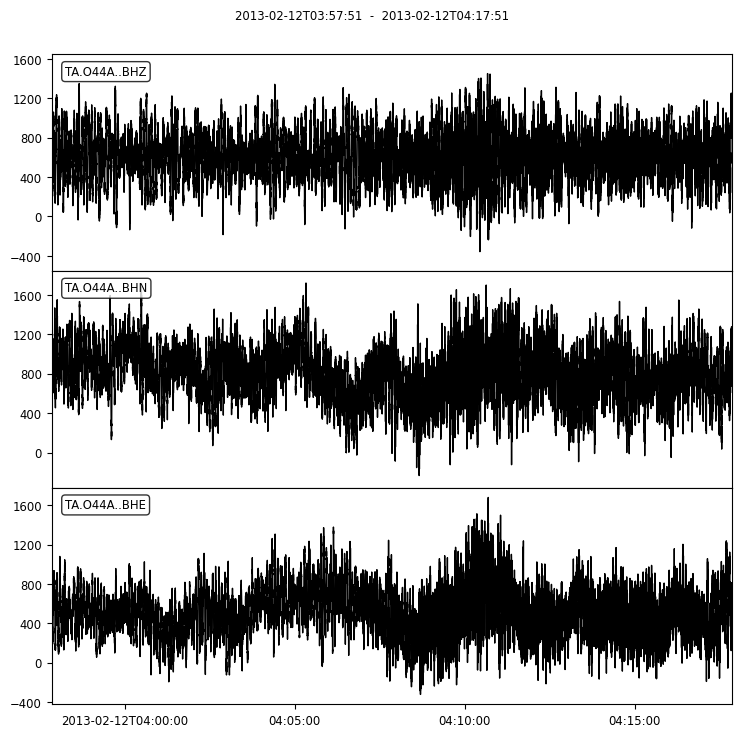

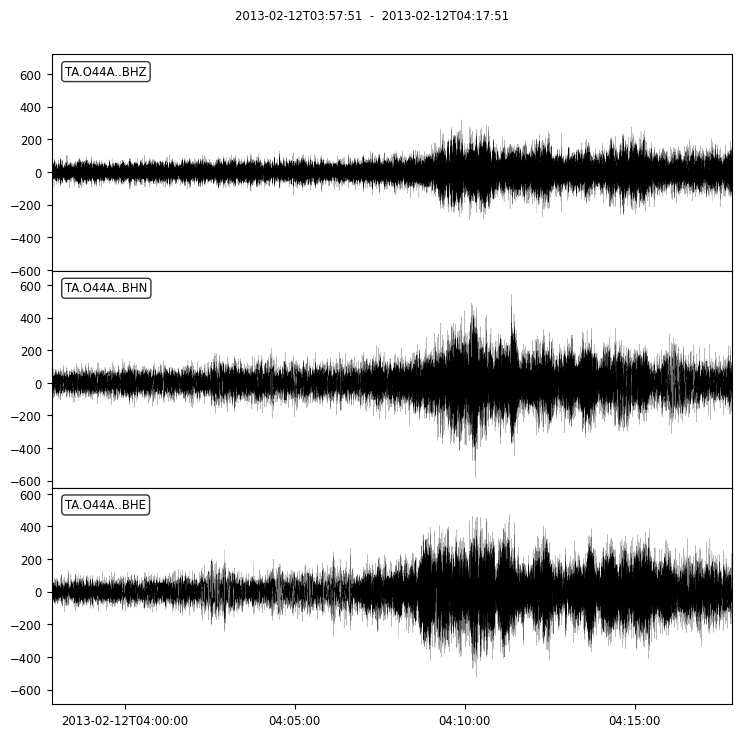

In [112]:
# We will plot twenty minutes of data recorded in Illinois starting an hour after the event occured in East Asia 

irisDataIL.plot()
irisDataIL_EDIT = irisDataIL.copy() #Filtering is done in-place on your data, so let's make a copy so we can keep our original data separate
irisDataIL_EDIT.filter("bandpass", freqmin=1, freqmax=10)
plottedData = irisDataIL_EDIT.plot(method='full', linewidth=0.1)

Now, let's look at data from the same event, but much closer to it (from a seismometer in Japan).

Note that we start our plot at the recorded event start time. 

The second plot below is in "relative" time, which means it is displayed as seconds after the starttime.

3 Trace(s) in Stream:
II.ERM.00.BH1 | 2013-02-12T02:57:51.019500Z - 2013-02-12T03:01:20.969500Z | 20.0 Hz, 4200 samples
II.ERM.00.BH2 | 2013-02-12T02:57:51.019500Z - 2013-02-12T03:01:20.969500Z | 20.0 Hz, 4200 samples
II.ERM.00.BHZ | 2013-02-12T02:57:51.019500Z - 2013-02-12T03:01:20.969500Z | 20.0 Hz, 4200 samples


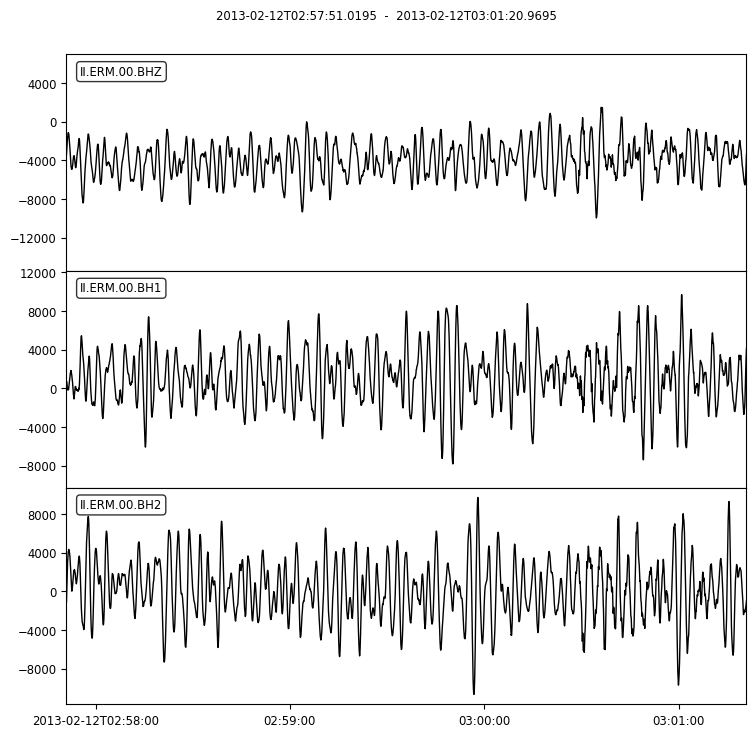

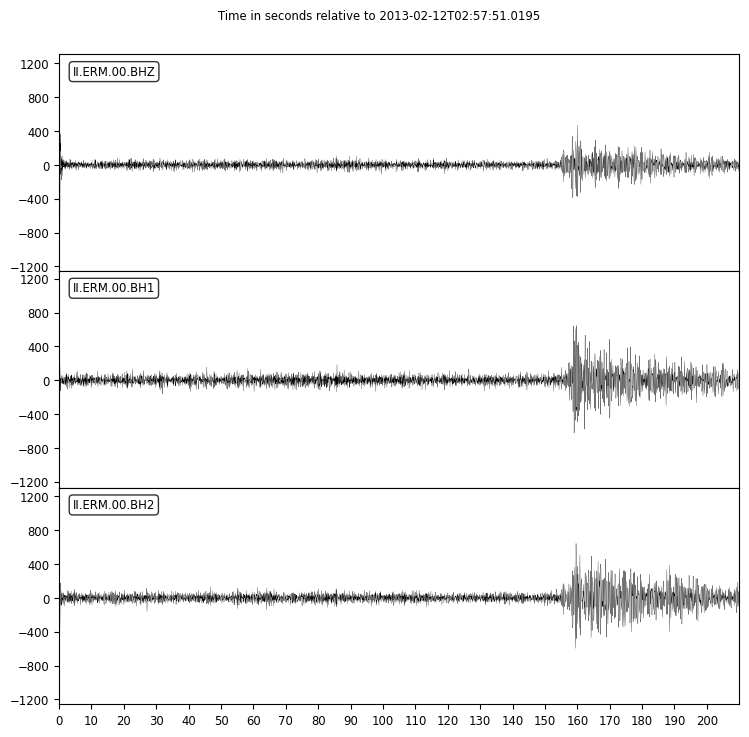

In [130]:
from obspy import UTCDateTime

#Now, let's set our parameters
# Info on get_waveforms() parameters: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html#obspy.clients.fdsn.client.Client.get_waveforms
# We need at minimum the network name, station name, location, channel, starttime, and endtime

# Let's specify parameters for 
net='II'
sta= "ERM"
loc='00'
cha='BH*'
eTime = eventTime + 210 # 3.5- minute record


irisDataJapan = irisClient.get_waveforms(network=net, 
                         station=sta, 
                         location=loc, 
                         channel=cha, 
                         starttime=eventTime, 
                         endtime=eTime)
print(irisDataJapan)
irisDataJapan.plot()
irisDataJapan_EDIT = irisDataJapan.copy()
irisDataJapan_EDIT.filter("bandpass", freqmin=2.5, freqmax=9.9)

# Code for plotting
plottedData = irisDataJapan_EDIT.plot(type='relative', linewidth=0.2, show=False)
ax = plottedData.get_axes()[2]
import matplotlib.pyplot as plt
plt.sca(ax)
import numpy as np
ax.set_xticks(np.arange(0, 210, 10))
plt.show()

Now, let's zoom in on the arrival time:

3 Trace(s) in Stream:
II.ERM.00.BH1 | 2013-02-12T03:00:11.019500Z - 2013-02-12T03:01:05.969500Z | 20.0 Hz, 1100 samples
II.ERM.00.BH2 | 2013-02-12T03:00:11.019500Z - 2013-02-12T03:01:05.969500Z | 20.0 Hz, 1100 samples
II.ERM.00.BHZ | 2013-02-12T03:00:11.019500Z - 2013-02-12T03:01:05.969500Z | 20.0 Hz, 1100 samples


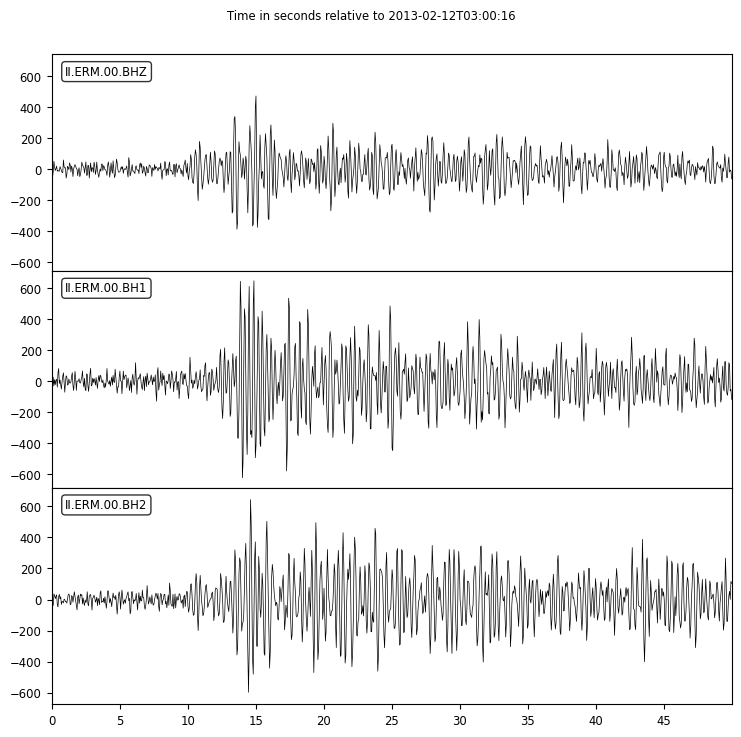

In [145]:
# Let's specify parameters for 
net='II'
sta= "ERM"
loc='00'
cha='BH*'

irisDataJapan = irisClient.get_waveforms(network=net, 
                                        station=sta, 
                                        location=loc, 
                                        channel=cha, 
                                        starttime=eventTime+140, 
                                        endtime=eventTime+195)

print(irisDataJapan)
irisDataJapan_EDIT = irisDataJapan.copy()
irisDataJapan_EDIT.filter("bandpass", freqmin=2.5, freqmax=9.9)

# Code for plotting
plottedData = irisDataJapan_EDIT.plot(type='relative', starttime=eventTime+145, linewidth=0.5, show=False)
ax = plottedData.get_axes()[2]
import matplotlib.pyplot as plt
plt.sca(ax)
import numpy as np
ax.set_xticks(np.arange(0, 50, 5))
plt.show()

You will need the following information to answer Question 4c:

For the ERM station (in the II network in Japan), note the following:
* The BHZ channel is oriented vertically
* The BH1 channel is oriented approximately North-South
* The BH2 channel is oriented approximately East-West

For the data stream:
* In this last code cell, we have set an arbitrary start time so that we can "zoom in" on the arrival of the seismic waves to the II.ERM station.
* There is a small initial set of waves that are visible between approximately 10-12 seconds into the record. These waves are oriented in the direction of travel (P waves).
* There are other sets of waves that arrive around 12 and 14 seconds into the record.
  * The exact timing of these waves would be important for precisely locating the source of the seismic data, but for now, we will just use approximations.


# Q4: (Answer these using the last three code cells you have run, in order)
# a) Given that the event occured on Feb 12, 2013 at 02:57:51 UTC, approximately how many minutes did it take to arrive to the seismometer in Illinois?
# b) Approximately how many seconds after the event occured did the main waves arrive at the ERM station in Japan? (your answer should be within 10 seconds or so).
# c) What differences do you see between BH1 and BH2 in the magnitude of the first set of waves (~10-12 seconds)? What does this imply about the direction of the source from the seismometer?

> NOTE: This seismic event was actually a nuclear bomb test undertaken by North Korea. 
>You can read more about it on the USGS Earthquake Database [here](https://earthquake.usgs.gov/earthquakes/eventpage/usc000f5t0/executive), Wikipedia [here](https://en.wikipedia.org/wiki/2013_North_Korean_nuclear_test), from NPR [here](https://www.npr.org/2013/02/12/171775235/north-korea-admits-it-carried-out-nuclear-test), CNN [here](https://www.cnn.com/2013/02/11/world/asia/north-korea-seismic-disturbance/index.html), and Al Jazeera [here](https://www.youtube.com/watch?v=RMdl9aa6ctI).

---

# Seismic Data: Local Site Analysis

So far in this exercise, you have carried out general overviews of seismic data in a way that is often used by geophysicists around the world. Because of the global (and large!) nature of seismic phenomena, seismic geophysics (i.e., seismology) is often carried out on global, continental, or at least regional scales.

Seismic data acquisition at smaller scales is generally divided up into two types: active source and passive source.

Some common methods used for these site-specific analyses are:
* Active source surveys:
    * Seismic reflection
    * Seismic refraction
    * (Multichannel) Analysis of Surface Waves (MASW) - more commonly an active source method
* Passive source surveys (using [seismic noise](https://en.wikipedia.org/wiki/Seismic_noise)):
    * Multichannel Analysis of Surface Waves (MASW) - may also be used with passive data
    * Horizontal to Vertical Seismic Ratio (HVSR)

For the rest of this exercise, you will carry out HVSR analysis on passive seismic data.

This data we will use for the last part of this exercise is included in the "SeismicSampleData" subfolder of the "Seismic" folder of the GEOL451 Github repository: `GEOL451/Seismic/SeismicSampleData`.


## HVSR Workflows

HVSR data is commonly used to delineate the depth to subsurface interfaces where there are large differences in acoustic impedence. It does this by calculating the "resonance frequency" of our data, largely from the horizontally-polarized surface waves. This contrasts with a relatively lack of resonance in the vertically-polarized surface waves. Ideally, we will find a "fundamental frequency" of the near-surface sediments/geologic formation where the horizontal waves resonate with a maximal amount of energy over the vertical waves. This creates a local maximum or "peak" in our H/V curve at a specific frequency.

HVSR is one of the few direct geologic/geophysical techniques that has been carried out on Earth, the Moon, and on Mars. This is because it requires only a single, three-component seismometer 
(you could carry this out with a two component seismometer as well, as long as one is vertical and one is horizontal).

HVSR is often used to delineate depth to bedrock in glaciated areas, or may be used for sounding the depth to other interfaces.

We will use the python package "Spectral Ratio Investigation Toolset" or SpRIT (pronounced "sprite") to do this.

Carrying out HVSR analysis with `sprit` can be done in a single line of code using the `sprit.run()` command, but we will go through each step individually here.

The general steps to carrying out HVSR analysis are:
1. Read in parameters and fetch data
2. **OPTIONAL**: Manipulate data to remove noise or generate azimuthal calculations
    * Since we are using passive data, "cultural" noise (i.e., from sources near the seismometer) can intefere with analysis. 
        * We often remove the data for that time from the further analysis
    * We may also rotate our data/calculate "azimuthal" seismic data to estimate the contribution of the H/V ratio from different directions
3. Carry out power spectral density (PSD) analysis using fourier transforms (i.e., create PSD curves)
    * Divide the data into (often overlapping) windows for analysis
        * By default in SpRIT, these windows are 30 seconds in length and overlap by 50%
    * Carry out fourier transforms on each component in each window to get a PSD curve for all windows/components
4. Calculate the H/V ratio for each window
    * For 3-component systems, this involves combining/averaging the PSD curve for the Horizontal components
    * We divide the (combined) PSD curve value at each frequency step for the Horizontal component in each window by the PSD curve value at each frequency step for the Vertical component (H/V)
5. Carry out post-processing on the H/V curve to identify key curve parameters
    * **OPTIONAL**: Remove any outlier curves for simpler analysis
    * Find the largest and/or most important "peak" in the curve (often, the fundamental frequency)
    * Test that peak against standard tests (see section 3.2 and 3.3 of [this document](https://sesame.geopsy.org/Papers/HV_User_Guidelines.pdf) for the most commonly used tests)
6. Visualize/communicate results

After collecting many HVSR soundings, you may also:

7. Create a depth model to convert fundamental frequencies to depths
8. Generate depth curves and subsurface profiles to visualize the soundings

In SpRIT, these steps are implemented via the following functions, the names of which should be fairly self-explanatory:
```python
import sprit

sprit.input_params()
sprit.fetch_data()
sprit.remove_noise()
sprit.generate_psds()
sprit.process_hvsr()
sprit.remove_outlier_curves()
sprit.check_peaks()
sprit.get_report()

```

Let's begin our process by setting up our `HVSRData` object in SpRIT, then by reading in the .mseed file from your SeismicSampleData folder.

The following information is true of our seismic data:
* Filepath (you will need to specify this for the `input_data` parameter)
* Site name (you may specify this (or not) however you like using the `site` parameter)
    * You may also choose to specify the `project` parameter or not
* Start time of record (`starttime` parameter): 
    * This will need to be an obspy `UTCDateTime` object
* End time of record (`endtime` parameter): 
    * This will need to be an obspy `UTCDateTime` object
* UTM Easting (`xcoord` parameter):
* UTM Northing (`ycoord` parameter):
    * You will need to specify the correct CRS for the `input_crs` parameter
    * Using [epsg.io](epsg.io), you can search for the correct EPSG identifer by searching "UTM 16N NAD83 2011"
    * You will want to set input_crs in this way: `input_crs="EPSG:####"` (replace ### with the proper EPSG identifying number of the CRS)
* Elevation (`elevation` parameter): 
    * This is in feet, so you either need to update the `elev_unit` parameter (`elev_unit='feet'`) or you need to convert this value to meters


First, explore your data using obspy. Use the cell below:

> **YOU MAY NEED TO UPDATE YOUR FILEPATH**

In [ ]:
import obspy
inputData = "/workspaces/GEOL451/Seismic/SeismicSampleData/GEOL451_SeismicData.mseed"
hvsrSeismicStream = obspy.read(inputData)
print(hvsrSeismicStream)

Now, use the information from the printout above and any data you can extract from the `stats` property of the traces to fill in the rest of the data for the `sprit.input_params()` parameters below

In [ ]:
# Do any other data exploration of hvsrSeismicStream here


# Q5: Provide the following information for the seismic data you will use for this HVSR point:
* Network name (two letter abbreviation) of the instrument (this will be your `network` parameter of `input_params`)
* Station name of the instrument (this will be your `station` parameter)
* Names of the channels (there should be three). 
    * Create a list and use it as your `channels` parameter (e.g., for the Japanese data above, it would be `channels=["BHZ", "BH1", "BH2"]` (note the quotes))
* Acquisition date
    * This will be your `acq_date` parameter, as a `datetime.date` object (see [here](https://docs.python.org/3/library/datetime.html#datetime.date) for more info on `datetime.date` objects)
* Duration/length of the data stream
* Sampling rate (number of samples per second)
* Total number of samples

---

In the following cell, you will need to specify your parameters. If you do this correctly, you should be able to also fetch your data with no issues.

In [ ]:
import sprit
hvsrDataIN = sprit.input_params(input_data=,
                            #site=,
                            #project=,
                            network=,
                            station=,
                            channels=[],
                            acq_date=,
                            starttime=,
                            endtime=,
                            xcoord=,
                            ycoord=,
                            input_crs=,
                            elevation=,
                            elev_unit=,
                            )
hvsrDataIN = sprit.fetch_data(hvsrDataIN)

You may explore the parameters of the following commands, but use the default values for your final analysis.

In [ ]:
hvsrData = sprit.generate_psds(hvsrDataIN)
hvsrResults = sprit.process_hvsr(hvsrData)
hvsrResults = sprit.check_peaks(hvsrResults)
hvsrResults = sprit.get_report(hvsrResults)

# Q6: Include a copy of just your plot OR a screenshot of the entire report.

# Q7: What did you calculate as fundamental frequency of your data?

---

Now, we will use a pre-derived depth model to estimate the depth to this subsurface interface.

This is commonly done by developing a regression relationship between known depths to the given subsurface interface and the fundamental frequencies.

Usually, depth models vary depending on geology/region, so they are generated uniquely for each region or site that is being worked on.

You will use example data to generate a depth model for this region using the data provided in the SeismicSampleData folder in the `hvsr_depth_data.csv` file. 

See instructions below:

In [ ]:
sprit.calibrate()

In [ ]:
sprit.calculate_depth(hvsrResults, depth_model=(1, 1))